# I - Motivation

## I - 1. Description of the dataset

The dataset is a compilation of data about [all road accidents that occured in Paris](https://opendata.paris.fr/explore/dataset/accidentologie/), France between January 1st of 2012 and December 31th of 2013. It includes the precise date and hour of each accident, along with the type of each vehicle involved (car, motorcycle, bicycle...), the gravity (heavily wounded, slightly wounded, unharmed, dead) and the arrondissement in which the accident occured.
An arrondissement is an administrative sub-division of Paris; each has its own specificity and sub-culture.

## I - 2. Actual motivation

We chose this dataset because we are both French, one of us is Parisian, and we wanted to test the quality of Paris Open Data, a quite young initiative. We also chose it because it contains tons of interesting information which are not limited to date and streets: there is geodata, as well as arrondissements, gravity and types of vehicles.

## I - 3. Goal

The goal for the end user experience is to, first, give some general information/fun facts about accidents occuring in Paris, especially to find some situations where the data is not organized as we would expect, and try to explain why, as well as finding expected patterns and explain why. But because prediction is also important when working in the data science field, the next goal will be to predict where an accident is most likely to occur given several pieces of information (hour, type of vehicle...). Finally, we will see if it is possible to roughly obtain the localization of the 20 arrondissements using the K-means algorithm, as some arrondissements are mainly pedestrians-only, and others only composed of big avenues.

# II - Basic stats

## II - 1. Preprocessing

The preprocessing of the data didn't require much work: it was well-ordered, and only 3 values were geographically not in Paris, so we cut them out. We also removed diacritics in the column names and street names, so that it would not require any more complicated UTF-8 processing.

## II - 2. Dataset stats

We plotted different things to see better the different angles of the accidents in Paris. First, we import all we need:

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
import datetime
import geoplotlib
import geoplotlib.utils
from sklearn import tree, preprocessing, model_selection
from sklearn.cluster import KMeans
import random
import csv

accidents_data = pandas.read_csv("accidentologie.csv", delimiter=";")

### II - 2. a. Repartition  of the accidents over the days of the week

Here, we plot the repartition of all road accidents over the course of the week:

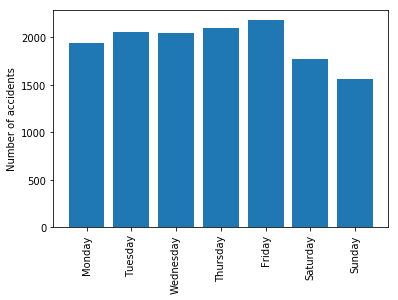

In [2]:
weekdays = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0}

for X in accidents_data["Date"]:
    date = X.split("-")
    year = int(date[0])
    month = int(date[1])
    day = int(date[2])
    
    date = datetime.date(year, month, day)
    iso_day = date.isoweekday()
    
    weekdays[iso_day] += 1

label_weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
xs = [i + 0.1 for i,_ in enumerate(weekdays)]

plt.bar(xs, weekdays.values())
plt.xticks(xs, label_weekdays, rotation="vertical")
plt.ylabel("Number of accidents")
plt.show()

We can see here that apparently vigilance tends to decrease over the course of the week, so that there is more accidents during the end of the week. The small peak on Friday might also be because people are driving under the influence; the lack of accidents during the week-end must be because there is less traffic on Saturday/Sunday, because people are not commuting.

### II - 2. b. Repartition of the accidents regarding the hours of the day

We plot the number of accidents for each hour of the day:

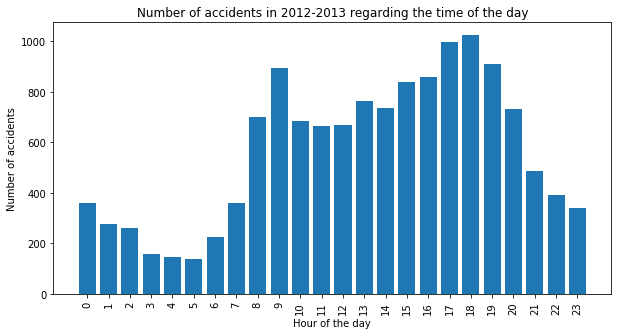

In [3]:
hours = { x: y for (x,y) in zip(range(24), [0]*24) }

for X in accidents_data["Heure"]:
    hour = int(X.split(":")[0])
    hours[hour] += 1
    
xs = [i + 0.1 for i,_ in enumerate(hours)]
fig = plt.figure(figsize=(10,5))

plt.bar(xs, (hours.values()))
plt.xticks(xs, (hours), rotation="vertical")
plt.xlabel("Hour of the day")
plt.ylabel("Number of accidents")
plt.title("Number of accidents in 2012-2013 regarding the time of the day")
plt.show()

We can see here that the accidents are not equally distributed over the course of the day. There is two visible peaks: one at 9 AM, and one at 17 - 18 PM. It corresponds to people commuting: more people are on the roads, so more accidents happen. <br />
We can also plot the number of accidents per hour for each day of the week, to see if peaks change:

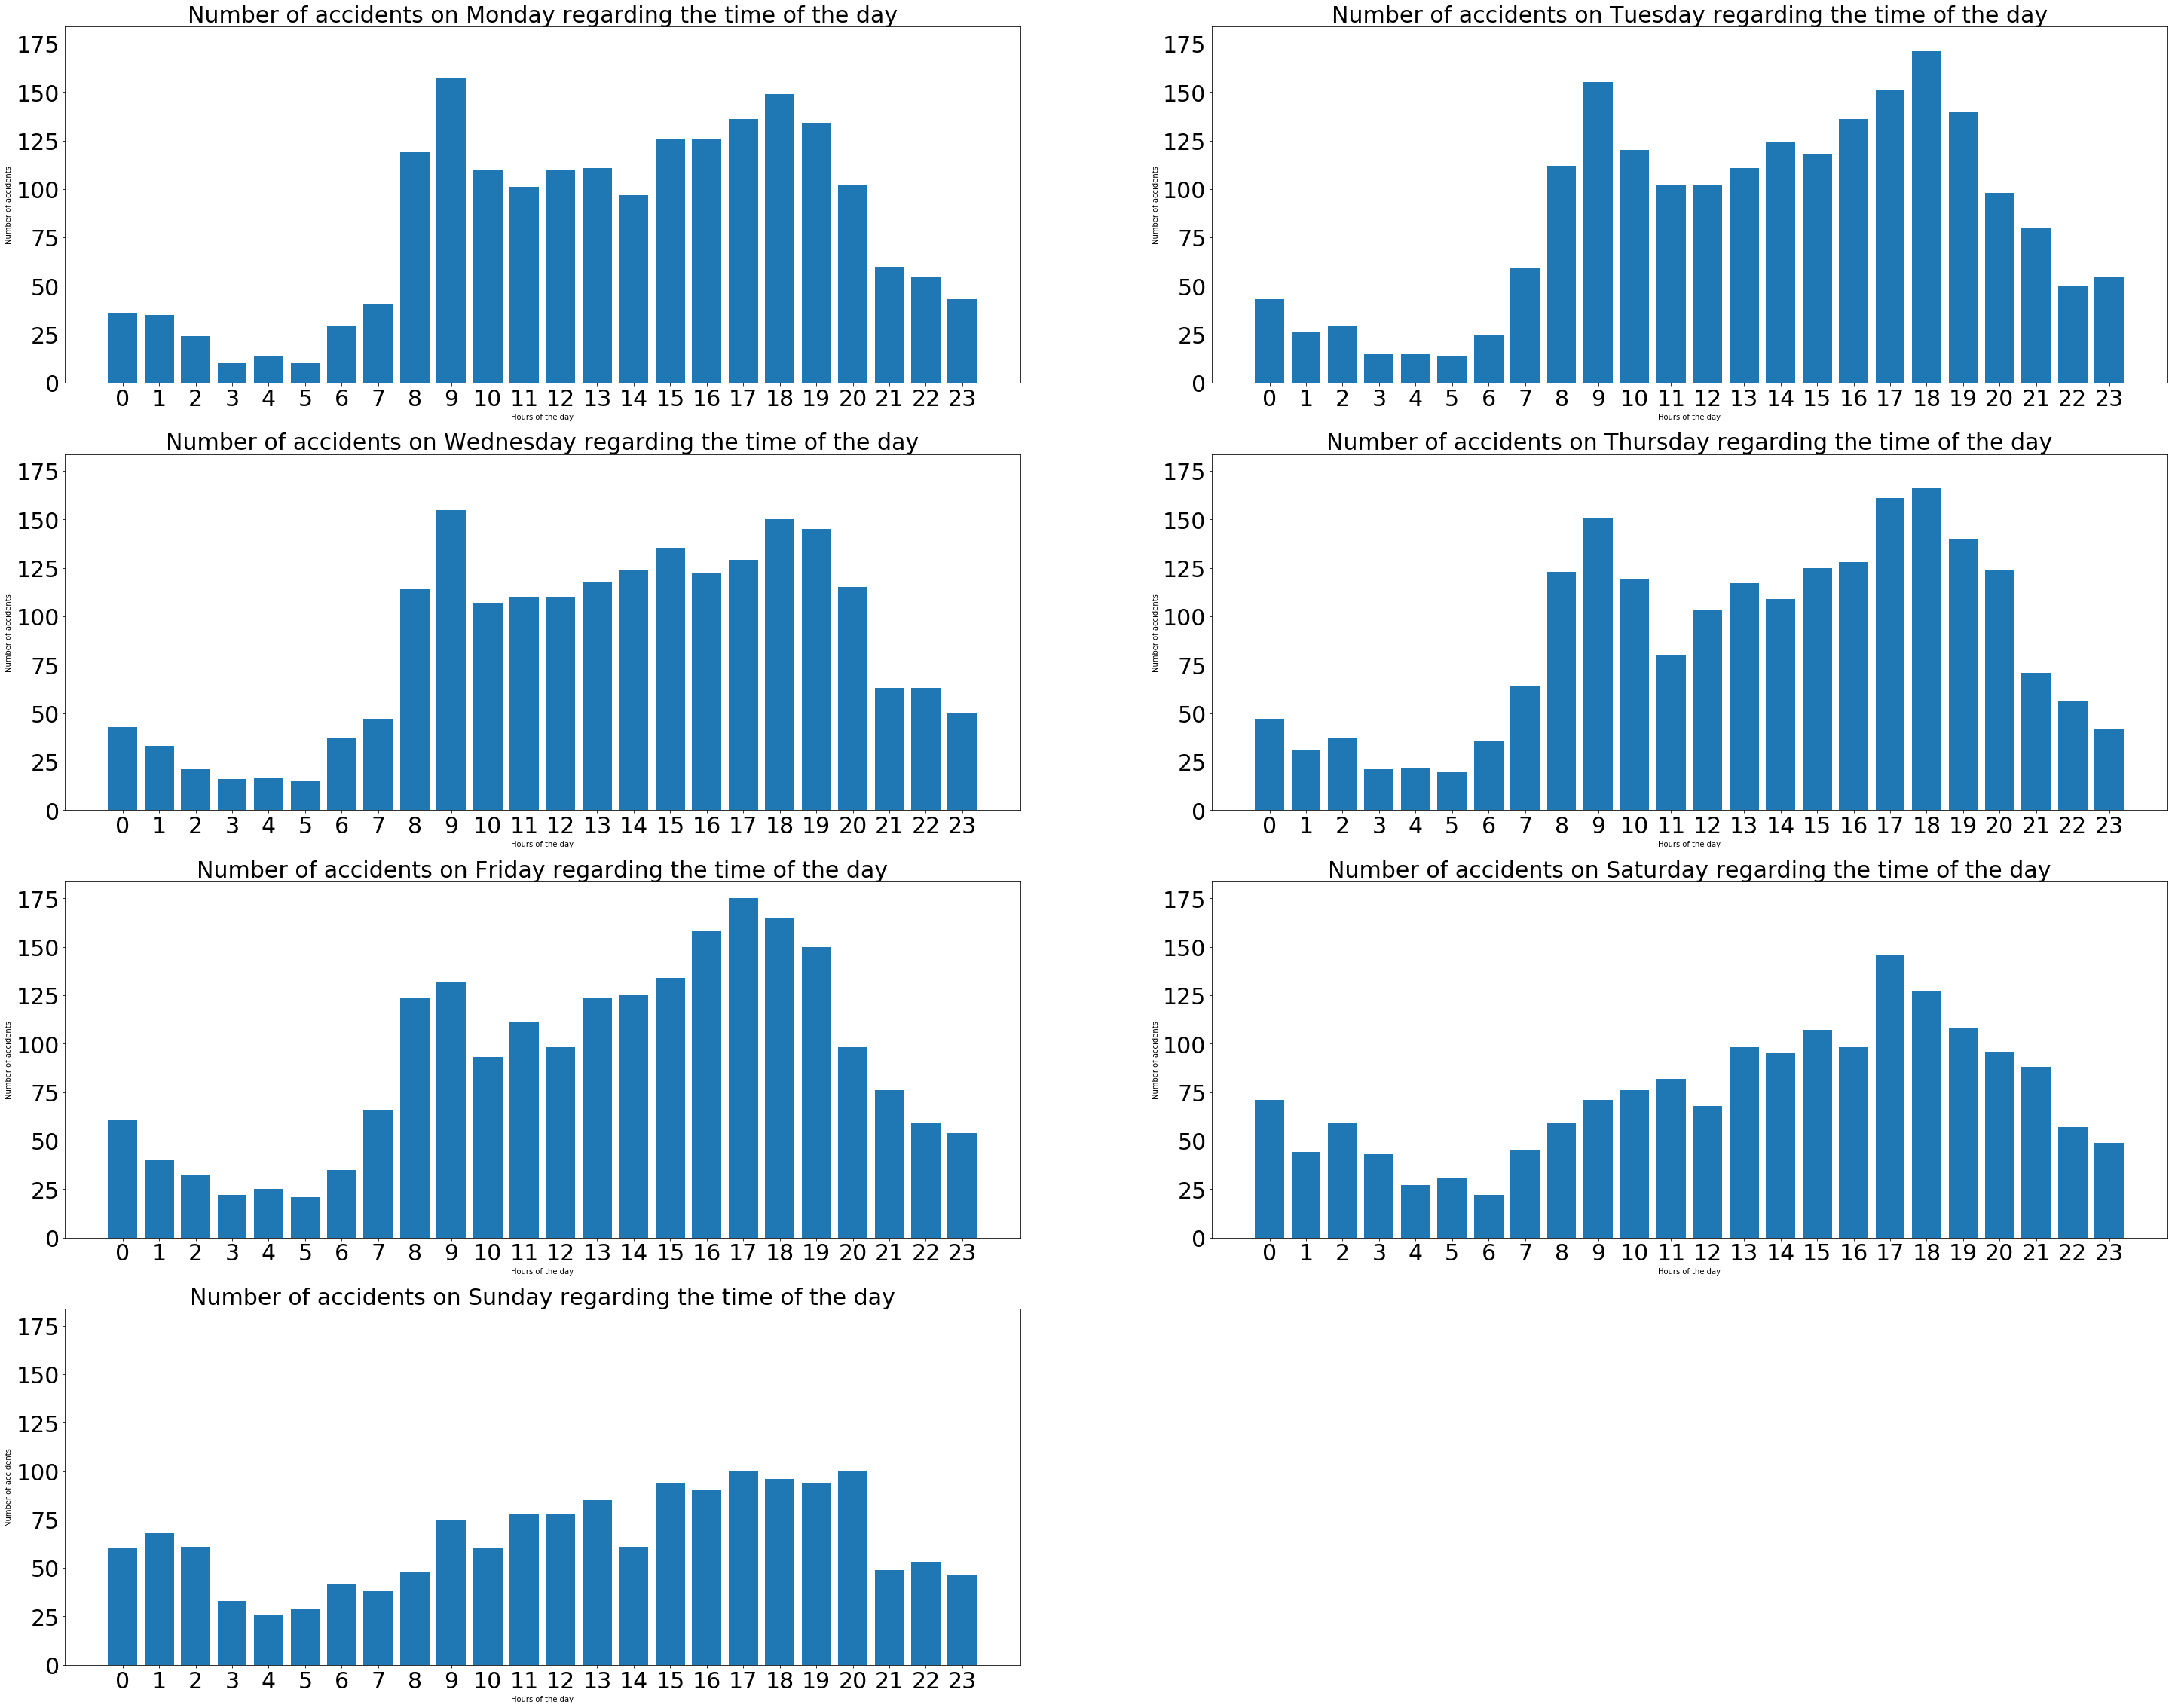

In [4]:
def dayOfWeek(date):
    date = date.split("-")
    year = int(date[0])
    month = int(date[1])
    day = int(date[2])
    
    date = datetime.date(year, month, day)
    iso_day = date.isoweekday()
    
    return iso_day;

fig = plt.figure(figsize=(50,40))

data = accidents_data[accidents_data.ix[:,0].apply(dayOfWeek) == 1]

hours = { x: y for (x,y) in zip(range(24), [0]*24) }

for X in data["Heure"]:
    hour = int(X.split(":")[0])
    hours[hour] += 1

xs = [i + 0.1 for i,_ in enumerate(hours)]

ax1 = plt.subplot(4,2,1)

plt.bar(xs, (hours.values()))
plt.xticks(xs, (hours))
plt.xlabel("Hours of the day")
plt.ylabel("Number of accidents")
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.title("Number of accidents on " + label_weekdays[0] + " regarding the time of the day", fontsize=30)


for k in range(2,8):
    narrowed_data = accidents_data[accidents_data.ix[:,0].apply(dayOfWeek) == k]

    hours = { x: y for (x,y) in zip(range(24), [0]*24) }

    for X in narrowed_data["Heure"]:
        hour = int(X.split(":")[0])
        hours[hour] += 1

    xs = [i + 0.1 for i,_ in enumerate(hours)]
    
    plt.subplot(4,2,k, sharey=ax1)
    
    plt.bar(xs, (hours.values()))
    plt.xticks(xs, (hours))
    plt.xlabel("Hours of the day")
    plt.ylabel("Number of accidents")
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.title("Number of accidents on " + label_weekdays[k-1] + " regarding the time of the day", fontsize=30)

plt.show()

We can see that our affirmations were correct: the peaks at 9 AM correspond to people commuting: they doesn't exist on Saturday and Sunday, when most people are resting. <br />
There is also more accidents occuring between 8 PM - 01 AM on Fridays, Saturdays on Sundays, are people are more likely to drive under the influence late at night - but not so much compared to other cities such as New-York and San-Francisco: usually people take the bus or metro to go home in Paris. <br />
A fun fact - the deeps on Saturday at 12 AM and on Sunday at 2 PM might be because people took their cars to visit their families for lunch, and then stay to do their afternoon nap (sieste).

### II - 2. c. Geographic repartition of the accidents

Because we want to be able to predict where accidents are most likely to occur, we are going to plot some preliminary geographical data. <br />
First, for the French/Parisian viewer's pleasure, let's plot the streets where most accidents are occuring (we cut down the périphérique though, the ring-road around Paris):

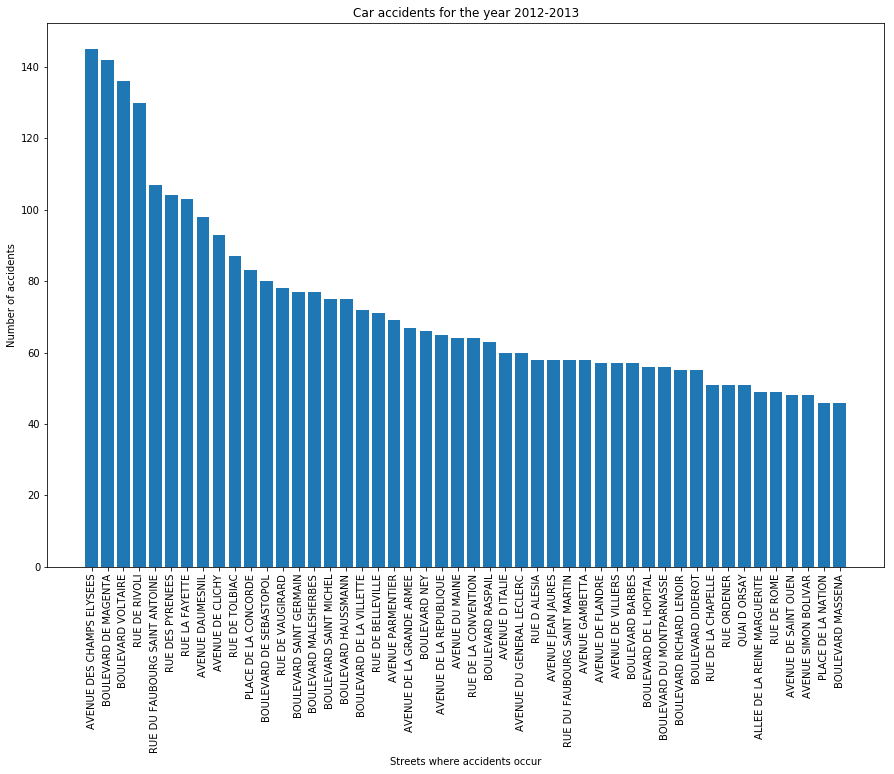

In [5]:
streets = (accidents_data.groupby(['Lieu 1 NomV']).size().reset_index().rename(columns={0:'count'})).sort_values(["count"], ascending=0)
occurences = streets[2:50]

xs = [i + 0.1 for i,_ in enumerate(occurences["count"])]

plt.figure(figsize=(15,10))
plt.bar(xs, occurences["count"])
plt.title("Car accidents for the year 2012-2013")
plt.xlabel("Streets where accidents occur")
plt.ylabel("Number of accidents")
plt.xticks(xs, occurences["Lieu 1 NomV"], rotation="vertical")
plt.show()

As said previously, Paris is divided between arrondissements. A map of all the arrondissements is shown below: ![Arrondissements](https://upload.wikimedia.org/wikipedia/commons/6/65/Arrondissements-de-Paris.png)

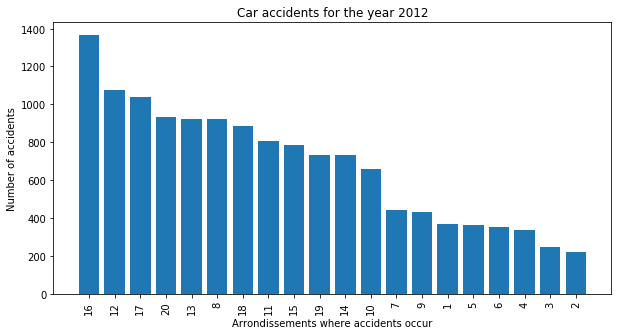

In [6]:
streets = (accidents_data.groupby(['Code postal']).size().reset_index().rename(columns={0:'count'})).sort_values(["count"], ascending=0)

for i,_ in enumerate(streets["Code postal"]):
    streets["Code postal"][i] = streets["Code postal"][i] - 75100

xs = [i + 0.1 for i,_ in enumerate(streets["count"])]

plt.figure(figsize=(10,5))
plt.bar(xs, streets["count"])
plt.title("Car accidents for the year 2012")
plt.xlabel("Arrondissements where accidents occur")
plt.ylabel("Number of accidents")
plt.xticks(xs, streets["Code postal"], rotation="vertical")
plt.show()

The results here are logical: the 16th, the 12th and the 17th are the "widest" ones, where most of Paris' traffic occurs, hence the accidents. The first ones are located on the center of Paris, where little traffic occurs (the Louvre, the Île de la Cité where Notre-Dame de Paris is...), hence far less accidents.

Finally, to sum up the situation, let's plot a heat map of the accidents:

In [7]:
longitudes = []
latitudes = []

for x in accidents_data["Coordonnees"]:
    if type(x) is str:
        longitudes.append(float(x.split(",")[1]))
        latitudes.append(float(x.split(",")[0]))

In [8]:
geo_data_for_plotting = { "lat": latitudes, "lon": longitudes }

geoplotlib.kde(geo_data_for_plotting, bw=5, cut_below=1e-04)
bbox = geoplotlib.utils.BoundingBox(north=max(latitudes), west=min(longitudes), south=min(latitudes), east=max(longitudes))

geoplotlib.set_bbox(bbox)
geoplotlib.inline()

('smallest non-zero count', 1.4329573088768091e-09)
('max count:', 0.55348730806882118)


### II - 2. d. Gravity plot

To conclude this list of broad plots, a plot of the number of accidents regarding their gravity:

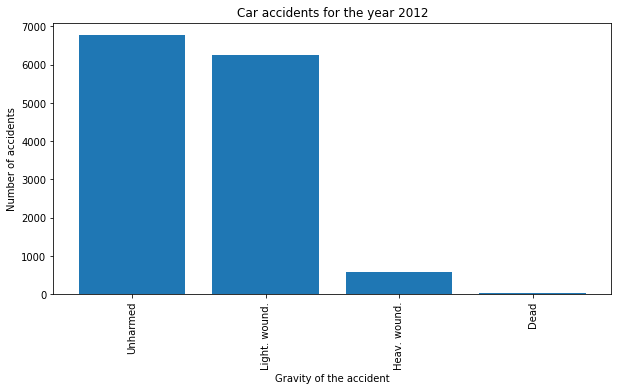

In [9]:
occurences = (accidents_data.groupby(['Usager 1 Grav']).size().reset_index().rename(columns={0:'count'})).sort_values(["count"], ascending=0)
english_wound_names = ["Unharmed", "Light. wound.", "Heav. wound.", "Dead"]
xs = [i + 0.1 for i,_ in enumerate(occurences["count"])]

plt.figure(figsize=(10,5))
plt.bar(xs, occurences["count"])
plt.title("Car accidents for the year 2012")
plt.xlabel("Gravity of the accident")
plt.ylabel("Number of accidents")
plt.xticks(xs, english_wound_names, rotation="vertical")
plt.show()

As we can see, "light" accidents are prevalent in respect to accidents where people are wounded/dead.

# III - Theory

## III - 1. Tools description

In this part, we will use sklearn's "train_test_split" built-in function in order to split the data between a training set and a validation set. We will make the training set ten times larger than the test set, which is a quite standard division, and we will split the data randomly using the same seeds for continuous examples, so that the error measurements make sense.

### III - 1. a. Decision trees

Our first goal is to predict in which arrondissement an accident is most likely to happen, given the type of vehicule / the hour of the day / the day of the week. <br />
To do so, we are first going to separate the vehicle list in types of vehicles that are likely to behave similarly given the hour of the day and their global mobility on the road:

In [10]:
bike = ["Bicy"]
public_transport = ["Bus", "Car"] # In French, "Car" stands for "Autocar" = "Coach" not the English "car"
two_wheels = ["Cyclo", "Moto50-125", "Moto>125", "Scoo50-125", "Scoo<=50", "Scoo>125"]
goods_truck = ["PL<=7,5", "PL>7,5"] # "PL" stands for "Poids Lourd" meaning "Heavy goods truck"
car = ["VL", "Voi"] # "VL" stands for "Véhicule Léger" = "Light Vehicle" = "Car", "Voi" stands for "Voiture" = "Car" 
others = ["Engin", "PLRem", "Q<=50", "Q>50", "TR", "TRSem", "Tram", "VU"] # Other vehicules, mostly public utilitary vehicles

vehicle_types = {"Bikes": bike, "Public transportation": public_transport, "Two wheels": two_wheels, "Goods trucks": goods_truck, "Cars": car, "Others": others}

In [11]:
vehicles_data = {};

for v_type,type_array in vehicle_types.iteritems():
    vehicles_data[v_type] = accidents_data[(accidents_data["Vehicule 1 Cadmin"].isin(type_array)) | (accidents_data["Vehicle 2 CAdmin"].isin(type_array)) | (accidents_data["Vehicule 3 CAdmin"].isin(type_array))]

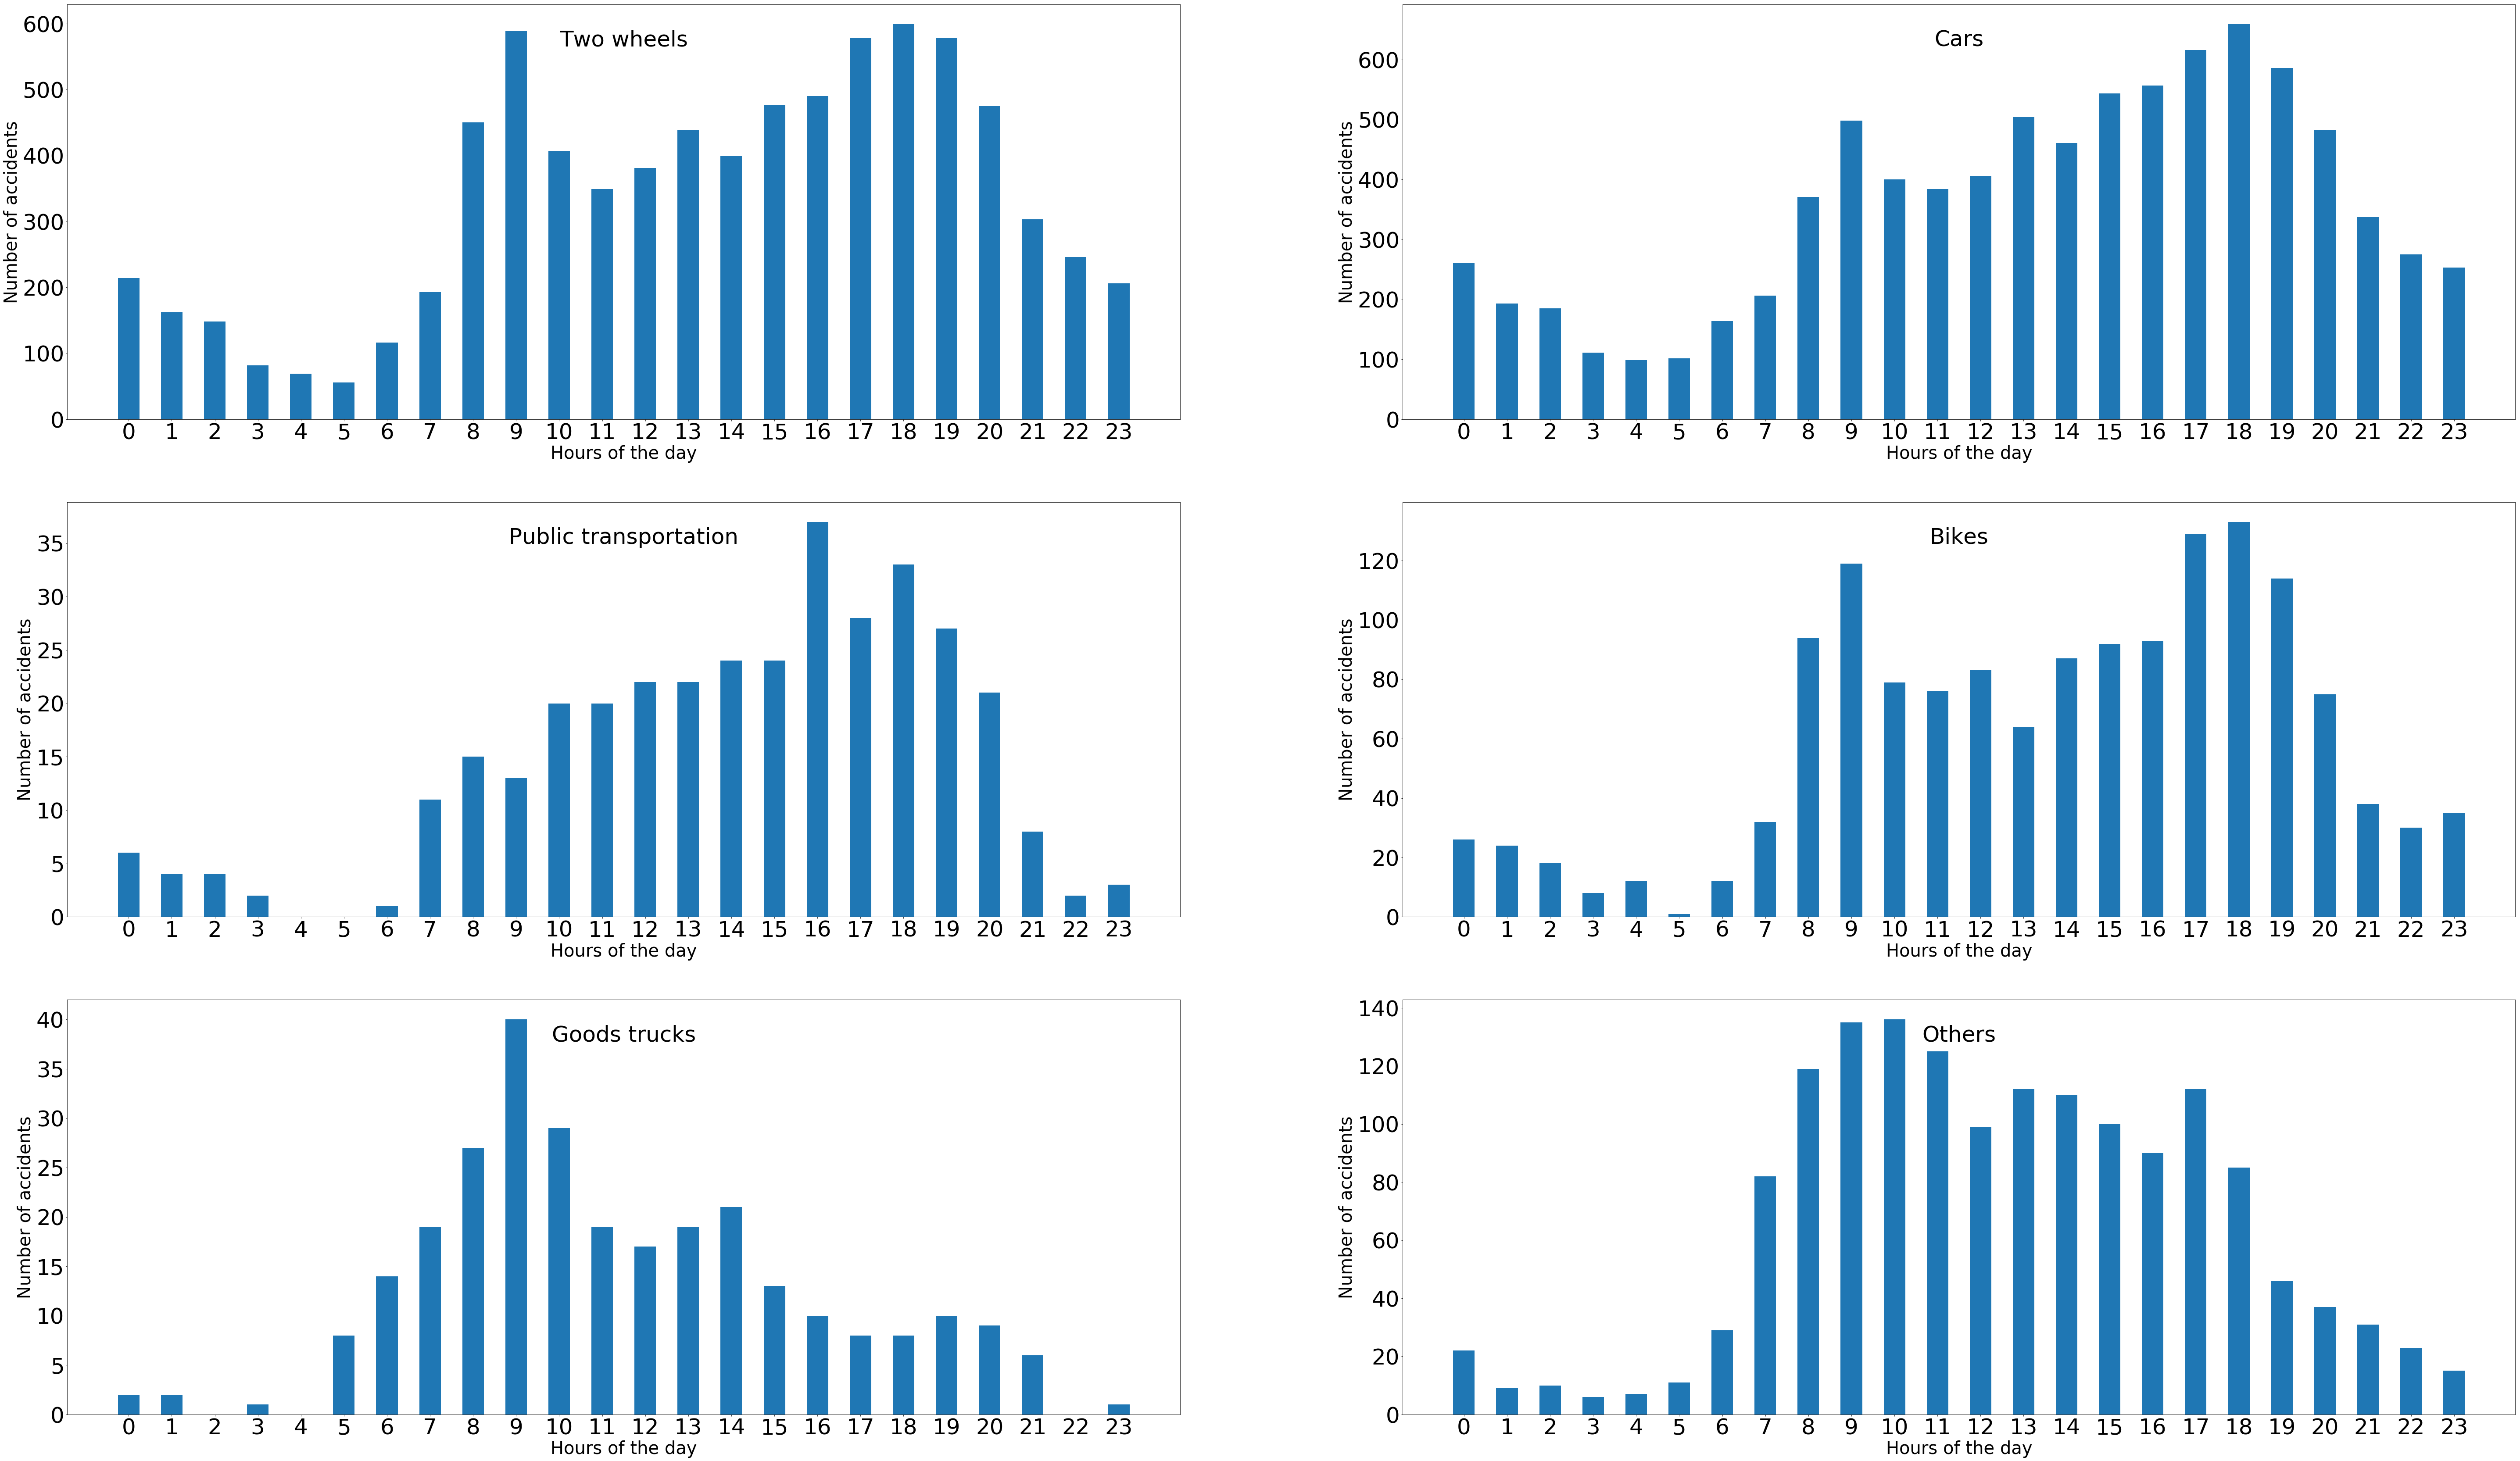

In [12]:
k = 1;
fig = plt.figure(figsize=(100,80))

for v_type,data in vehicles_data.iteritems():
    
    hours = { x: y for (x,y) in zip(range(24), [0]*24) }
    for X in data["Heure"]:
        hour = int(X.split(":")[0])
        hours[hour] += 1
        
    xs = [i + 0.1 for i,_ in enumerate(hours)]

    ax = plt.subplot(4,2,k)
    ax.text(.5,.9, v_type,
        horizontalalignment='center',
        transform=ax.transAxes, fontsize=50)
    plt.bar(xs, (hours.values()), width=0.5)
    plt.xticks(fontsize=50)
    plt.yticks(fontsize=50)
    k += 1
    plt.xticks(xs, (hours), rotation="horizontal")
    plt.xlabel("Hours of the day", fontsize=40)
    plt.ylabel("Number of accidents", fontsize=40)

plt.show()

Here we can see that apart from two wheels / cars / bikes and other, we don't really have enough data to make predictions over the other types. <br />
On a side note, we can see that the accidents occur somehow at different hours depending on whether it's a motorized two-wheels/car or a bike. <br />
But let us begin with the machine-learning! As we said before, the goal of this part is to predict in which arrondissement an accident will occur given the hour of the day, the day of the week and the type of vehicle using a decision tree (this choice is obvious, as seen in week 5). We already segregated vehicles in different broad categories.<br /> <br />

The error measurement here will be made by trying to predict the corresponding arrondissement's accident given the hour and the vehicle category for the whole test set, and compare the result to where it really happened.

In [28]:
def fun_vehicle_type(vehicle):
    for x,y in vehicle_types.iteritems():
        if vehicle in y:
            return x

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(numpy.transpose([accidents_data["Heure"].apply(lambda x: x.split(":")[0]),\
    accidents_data["Vehicule 1 Cadmin"].apply(fun_vehicle_type)]), accidents_data["Code postal"], test_size=0.1, random_state=10)

le1 = preprocessing.LabelEncoder()
le1.fit(numpy.array(X_train.flatten()))
X_train = numpy.array(map(le1.transform, X_train))

le2 = preprocessing.LabelEncoder()
Y_train = le2.fit_transform(Y_train)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, Y_train)

X_test = numpy.array(map(le1.transform, X_test))
Y_test = le2.transform(Y_test)

districts_predicted = clf.predict(X_test)
success_percentage = numpy.mean(districts_predicted == Y_test)*100
print "There is " + str(success_percentage) + " percent of correct guesses using decision trees."
 
hash_list = numpy.unique(Y_train)

random_districts = [random.choice(hash_list) for i in Y_test]
success_percentage_rand = numpy.mean(random_districts == Y_test)*100
print "Guessing randomly would yield a " + str(success_percentage_rand) + " percentage of correct guesses."

There is 10.1247248716 percent of correct guesses using decision trees.
Guessing randomly would yield a 4.69552457814 percentage of correct guesses.


The results are a bit disappointing here. We only have a 5% accurateness gain when we use decision trees with hours and vehicle types. <br />
Let's try to add the day of the week as well; as we saw above, during the week the accidents' repartition is quite the same, except for the week-end. So, instead of taking each day of the week individually, we are going to bucket it in week days and week-end:

In [14]:
def fun_day_type(date):
    day = dayOfWeek(date)
    if day in [6,7]:
        return "Week-end"
    elif day in [1,2,3,4,5]:
        return "Week day"
    
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(numpy.transpose([accidents_data["Heure"].apply(lambda x: x.split(":")[0]),\
    accidents_data["Vehicule 1 Cadmin"].apply(fun_vehicle_type), accidents_data["Date"].apply(fun_day_type)]), \
    accidents_data["Code postal"], test_size=0.1, random_state=10)

le1 = preprocessing.LabelEncoder()
le1.fit(numpy.array(X_train.flatten()))
X_train = numpy.array(map(le1.transform, X_train))

le2 = preprocessing.LabelEncoder()
Y_train = le2.fit_transform(Y_train)

clf = tree.DecisionTreeClassifier()
clf.fit(X_train, Y_train)

X_test = numpy.array(map(le1.transform, X_test))
Y_test = le2.transform(Y_test)

arrondissements_predicted = clf.predict(X_test)
success_percentage = numpy.mean(arrondissements_predicted == Y_test)*100
print "There is " + str(success_percentage) + " percent of correct guesses using the decision trees with an additionnal variable"
 
hash_list = numpy.unique(Y_train)

random_arrondissements = [random.choice(hash_list) for i in Y_test]
success_percentage_rand = numpy.mean(random_arrondissements == Y_test)*100
print "Guessing randomly would yield a " + str(success_percentage_rand) + " percentage of correct guesses."

There is 9.24431401321 percent of correct guesses using the decision trees with an additionnal variable
Guessing randomly would yield a 4.32868672047 percentage of correct guesses.


As we can see, there is not an outstanding better result obtained by adding another variable - it is actually worse. After a bit of fiddling, we find out that our first setting was the one leading to the best results. Maybe we will have a better luck by trying to do the reverse, though: trying to retrieve the arrondissements by the K-Means algorithm.

### III - 1. b. K-Means algorithm

Before applying the K-Means algorithm, we have to check if it is actually meaningful, by using the "knee" technique. That's what we will do here:

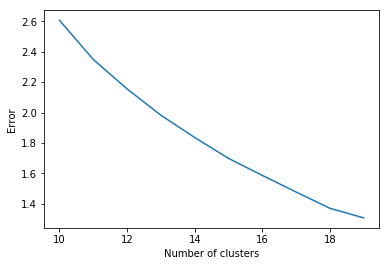

In [15]:
X = numpy.array([[x,y] for x,y in zip(latitudes,longitudes)])

errors = []

for k in range(1,10):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(zip(latitudes, longitudes))
    labels = kmeans.labels_
    error = 0

    for num_cluster in numpy.unique(labels):
        cluster = X[labels == num_cluster]
        cluster_mean = numpy.mean(cluster, axis=0)
        error += sum(numpy.linalg.norm(x-cluster_mean)**2 for x in cluster)
    errors.append(error)

plt.xlabel("Number of clusters")
plt.ylabel("Error")
plt.plot(range(1,10), errors)
plt.show()

errors = []

for k in range(10,20):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(zip(latitudes, longitudes))
    labels = kmeans.labels_
    error = 0

    for num_cluster in numpy.unique(labels):
        cluster = X[labels == num_cluster]
        cluster_mean = numpy.mean(cluster, axis=0)
        error += sum(numpy.linalg.norm(x-cluster_mean)**2 for x in cluster)
    errors.append(error)

plt.xlabel("Number of clusters")
plt.ylabel("Error")
plt.plot(range(10,20), errors)
plt.show()

As we can see in the lack of knee, maybe trying to find the arrondissements location only using K-Means on accidents was a bit optimistic. Let's try to see how the points are distributed here though:

In [16]:
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(zip(latitudes, longitudes))
centers = kmeans.cluster_centers_

labels = kmeans.labels_
latitudes_labels1 = [latitudes[i] for (i,X) in enumerate(latitudes) if labels[i] == 1]
longitudes_labels1 = [longitudes[i] for (i,X) in enumerate(longitudes) if labels[i] == 1]
latitudes_labels2 = [latitudes[i] for (i,X) in enumerate(latitudes) if labels[i] == 0]
longitudes_labels2 = [longitudes[i] for (i,X) in enumerate(longitudes) if labels[i] == 0]

latitudes_centroid = [centers[0][0], centers[1][0]]
longitudes_centroid = [centers[0][1], centers[1][1]]

geo_data_for_plotting = {"lat": latitudes_centroid, "lon": longitudes_centroid}
geoplotlib.dot(geo_data_for_plotting, point_size=10,color = "red")
geo_data_for_plotting = {"lat": latitudes_labels1, "lon": longitudes_labels1}
geoplotlib.dot(geo_data_for_plotting, point_size=3, color="blue")
geo_data_for_plotting = {"lat": latitudes_labels2, "lon": longitudes_labels2}
geoplotlib.dot(geo_data_for_plotting, point_size=3, color="black")


bbox = geoplotlib.utils.BoundingBox(north=max(latitudes), west=min(longitudes), south=min(latitudes), east=max(longitudes))
geoplotlib.set_bbox(bbox)
geoplotlib.inline()

This was expected, but disappointing: it is just two halves of a circle. Because of the failure of this experiment, no error measurement can take place.<br />
The initial intended error measurement was first to see if the 20 arrondissements were globally shown, and if so, to label each of the group to the closest arrondissement, and see the percentage of points that are shown in the bad arrondissement.

### III - 1. c. Bonus: gravity analysis

Finally, as a little bonus, a failed attempt to find the most dangerous places in Paris in terms of accidents.<br />
The people dead by road accidents are shown in red, while the heavily wounded people in black.

In [17]:
tues = accidents_data[(accidents_data["Usager 1 Grav"] == "Tue") | (accidents_data["Usager 2 Grav"] == "Tue") |\
               (accidents_data["Usager 3 Grav"] == "Tue") | (accidents_data["Usager 4 Grav"] == "Tue")]

blesses = accidents_data[(accidents_data["Usager 1 Grav"] == "BH") | (accidents_data["Usager 2 Grav"] == "BH") |\
               (accidents_data["Usager 3 Grav"] == "BH") | (accidents_data["Usager 4 Grav"] == "BH")]


latitudes_tues = []
longitudes_tues = []

latitudes_blesses = []
longitudes_blesses = []


for x in tues["Coordonnees"]:
    if type(x) is str:
        longitudes_tues.append(float(x.split(",")[1]))
        latitudes_tues.append(float(x.split(",")[0]))

for x in blesses["Coordonnees"]:
    if type(x) is str:
        longitudes_blesses.append(float(x.split(",")[1]))
        latitudes_blesses.append(float(x.split(",")[0]))
        
geo_data_for_plotting = { "lat": latitudes_tues, "lon": longitudes_tues}
geoplotlib.dot(geo_data_for_plotting, color="red", point_size=10)
geo_data_for_plotting = { "lat": latitudes_blesses, "lon": longitudes_blesses}
geoplotlib.dot(geo_data_for_plotting, color="black")
bbox = geoplotlib.utils.BoundingBox(north=max(latitudes), west=min(longitudes), south=min(latitudes), east=max(longitudes))

geoplotlib.set_bbox(bbox)
geoplotlib.inline()

Indeed, we tried to see if there was some places more dangerous than the others, but it seems that the accidents occur in random places; so, this report could be considered as a road safety annoucement: accidents can occur anywhere.

# IV - Visualizations

Because the machine-learning part didn't predict exactly what we wanted, we did a website centered on what data science is like, to show what can be done - and what can sometimes fail - to an unexperienced reader.

## IV - 1. Zoom in precision

First, we get inspiration for the preliminary data exploration done in part II. We want the viewer to feel what we can do in data analysis with a global approach at first, and then narrowing it down to observe different patterns. <br />
Here, we will first show him the repartition of accidents over the course of the week using a boring bar chart. This will then change by showing, still on a bar chart, the repartition of accidents over the course of the day; still the same bar chart, but with a different approach. Finally, we will make him be able to choose between the days of the week, in the same bar chart. That way, he will have a third approach on something that might seemed trivial at first - temporal sight on the accident data.<br />
We felt that it was the right way to make the reader see how the same data can be seen and analyzed in many different way, while maintaining the "fun fact" side, allowing him not only to broaden his understanding of data analysis, but also learning things on when and where accidents happen in Paris.

Here is the code used to generate easily the data to plot in d3:

In [18]:
for i,X in enumerate(label_weekdays,1):
    narrowed_data = accidents_data[accidents_data.ix[:,0].apply(dayOfWeek) == i]
    hours = { x: y for (x,y) in zip(range(24), [0]*24) }

    for Z in narrowed_data["Heure"]:
        hour = int(Z.split(":")[0])
        hours[hour] += 1

    string = "["
    for x,y in hours.iteritems():
        string += "[\"" + str(x) + "\"," + str(y) + "]" + ","

    print string

[["0",36],["1",35],["2",24],["3",10],["4",14],["5",10],["6",29],["7",41],["8",119],["9",157],["10",110],["11",101],["12",110],["13",111],["14",97],["15",126],["16",126],["17",136],["18",149],["19",134],["20",102],["21",60],["22",55],["23",43],
[["0",43],["1",26],["2",29],["3",15],["4",15],["5",14],["6",25],["7",59],["8",112],["9",155],["10",120],["11",102],["12",102],["13",111],["14",124],["15",118],["16",136],["17",151],["18",171],["19",140],["20",98],["21",80],["22",50],["23",55],
[["0",43],["1",33],["2",21],["3",16],["4",17],["5",15],["6",37],["7",47],["8",114],["9",155],["10",107],["11",110],["12",110],["13",118],["14",124],["15",135],["16",122],["17",129],["18",150],["19",145],["20",115],["21",63],["22",63],["23",50],
[["0",47],["1",31],["2",37],["3",21],["4",22],["5",20],["6",36],["7",64],["8",123],["9",151],["10",119],["11",80],["12",103],["13",117],["14",109],["15",125],["16",128],["17",161],["18",166],["19",140],["20",124],["21",71],["22",56],["23",42],
[["0",61],["1",40],["2"

## IV - 2. Map plot

We split this visualization in two parts: the first one, showing the map of all accidents that occured in Paris between 2012 and 2013, and the second one showing how we failed at predicting correctly the arrondissement for accidents occuring in our test dataset. We want to show the reader that data science is not something exact, and can sometimes fail - but still is a good bit of fun.<br />
By showing in the IV - 1. the power of data science, and in IV - 2., we wanted to stress that data science is not an ultimate thing for every problem, which seems to be the trend these days with every company hiring data scientists all around - and can sometimes even be [dangerous](https://arstechnica.co.uk/security/2016/02/the-nsas-skynet-program-may-be-killing-thousands-of-innocent-people/).

Here is the code used to generate the CSV files for the plot:

In [19]:
with open('html/accidents.csv', 'wb') as csvfile:
    accidentwriter = csv.writer(csvfile, delimiter=',',
        quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for x,y in zip(longitudes,latitudes):
        accidentwriter.writerow([x,y])

In [ ]:
X_train_plot, X_test_plot, Y_train_plot, Y_test_plot = model_selection.train_test_split(numpy.transpose([accidents_data["Heure"].apply(lambda x: x.split(":")[0]),\
    accidents_data["Vehicule 1 Cadmin"].apply(fun_vehicle_type), accidents_data["Coordonnees"]]), accidents_data["Code postal"], test_size=0.1, random_state=10)

coordinates_ok = []
coordinates_wrong = []

for i,truth_value in enumerate(districts_predicted == Y_test):
    if type(X_test_plot[i][2]) == str:
        longitude = float(X_test_plot[i][2].split(",")[1])
        latitude = float(X_test_plot[i][2].split(",")[0])
        if truth_value:
            coordinates_ok.append([longitude, latitude])
        else:
            coordinates_wrong.append([longitude, latitude])

longitudes_ok = [x for x,_ in coordinates_ok]
latitudes_ok = [y for _,y in coordinates_ok]
longitudes_wrong = [x for x,_ in coordinates_wrong]
latitudes_wrong = [y for _,y in coordinates_wrong]

with open('html/accidents_ok.csv', 'wb') as csvfile:
    accidentwriter = csv.writer(csvfile, delimiter=',',
        quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for x,y in zip(longitudes_ok,latitudes_ok):
        accidentwriter.writerow([x,y])

with open('html/accidents_wrong.csv', 'wb') as csvfile:
    accidentwriter = csv.writer(csvfile, delimiter=',',
        quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for x,y in zip(longitudes_wrong,latitudes_wrong):
        accidentwriter.writerow([x,y])

# V - Discussion

## V - 1. Things that went well

We managed to get very interesting information about Paris' road accidents; even if the machine-learning results are a bit disappointing, the time-related plots gave us some hindsight about Parisian's whereabouts. We are also glad to have managed to get all the visualizations we wanted fully working, and looking not so bad.

## V - 1. Things that are missing

We were quite unsuccessful on our attempts to use various machine-learning algorithms. We also would've liked to have more years available for accident's data, to see if road security awareness conducted by France's government worked and disminished the proportion of accidents given Paris population. More data could also have ruled out the fact the machine-learning algorithms didn't work because of the lack of data.